In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arrow

# Configuration
X_SIZE = 162
Y_SIZE = 130
START_COORD = (-1, -1)

class SwitchBox:
    def __init__(self, x, y, sb_type):
        self.x = x
        self.y = y
        self.type = sb_type
        
        # Input capacities (direction: max inputs)
        self.input_capacity = {
            'N': 6 if sb_type == 'big' else 2,
            'E': 6 if sb_type == 'big' else 2,
            'S': 6 if sb_type == 'big' else 2,
            'W': 6 if sb_type == 'big' else 2,
            'BL': 1,
            'TR': 1,
            'S_diag': 1,  # Additional diagonal input on S
            'W_diag': 1   # Additional diagonal input on W
        }
        
        # Output connections (direction: target coordinates)
        self.outputs = {
            'N': None,
            'E': None,
            'S': None,
            'W': None,
            'BL': None,
            'TR': None
        }

def generate_grid():
    grid = {}
    x = START_COORD[0]
    while x <= X_SIZE + 1:
        y = START_COORD[1]
        while y <= Y_SIZE + 1:
            if (x == X_SIZE + 2 and y == -1) or (x == -1 and y == Y_SIZE + 2):
                y += 2
                continue
            steps_x = (x - START_COORD[0]) // 2
            steps_y = (y - START_COORD[1]) // 2
            sb_type = 'big' if (steps_x + steps_y) % 2 == 0 else 'small'
            grid[(x, y)] = SwitchBox(x, y, sb_type)
            y += 2
        x += 2
    return grid

grid = generate_grid()
print(f"Total SBs: {len(grid)}")

# Connect neighboring SBs
for coord, sb in grid.items():
    x, y = coord
    
    # Cardinal directions
    neighbors = {
        'N': (x, y+2),
        'E': (x+2, y),
        'S': (x, y-2),
        'W': (x-2, y)
    }
    
    for direction, target in neighbors.items():
        if target in grid:
            sb.outputs[direction] = target

    # Diagonal connections
    diag_neighbors = {
        'BL': (x-2, y-2),
        'TR': (x+2, y+2)
    }
    
    for direction, target in diag_neighbors.items():
        if target in grid:
            sb.outputs[direction] = target

# Handle special edge connections
special_sources = [
    (X_SIZE + 1, -1),
    (-1, Y_SIZE + 1)
]
for src in special_sources:
    if src in grid:
        grid[src].outputs['TR'] = (X_SIZE + 2, 0) if src[0] == X_SIZE + 1 else (0, Y_SIZE + 2)


Total SBs: 5561


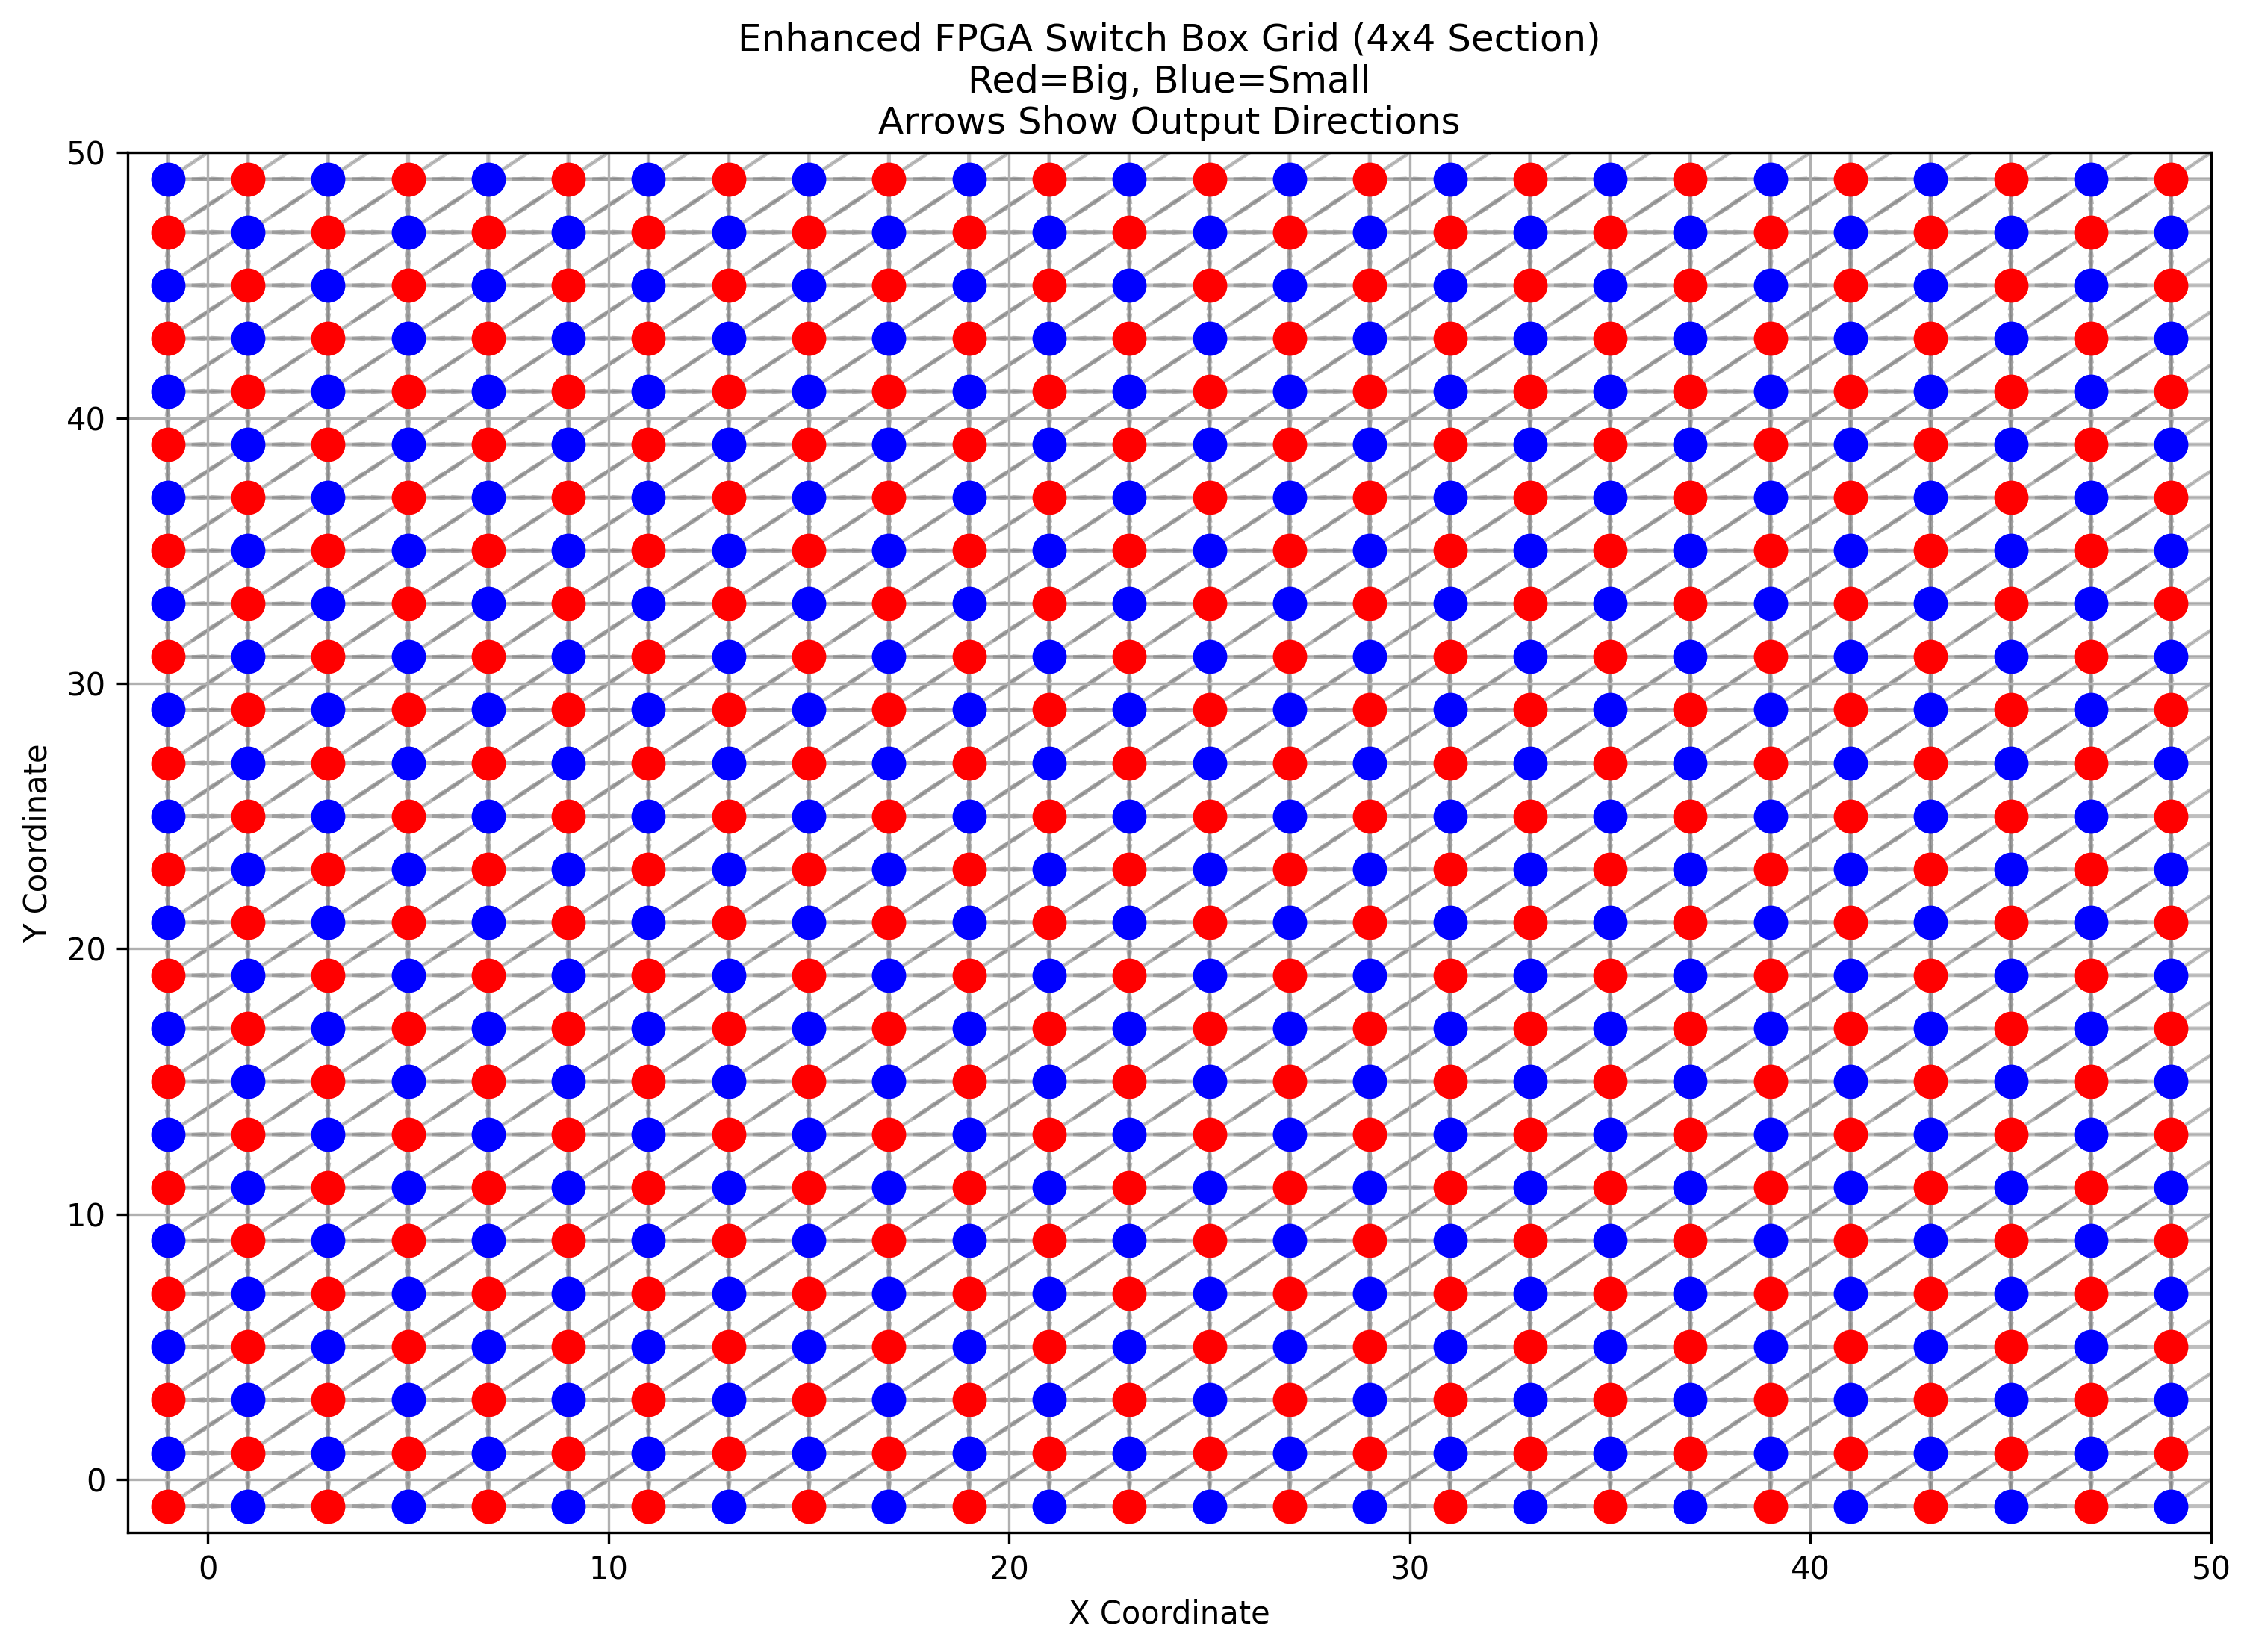

In [7]:
# Visualization of a 4x4 section
plt.figure(figsize=(12, 8), dpi=300)
ax = plt.gca()

# Plot SBs
plot_range = range(-1, 50, 2)  # From -1 to 5 in steps of 2
for x in plot_range:
    for y in plot_range:
        if (x, y) not in grid:
            continue
        sb = grid[(x, y)]
        color = 'red' if sb.type == 'big' else 'blue'
        plt.plot(x, y, 'o', markersize=10, color=color)
        
        # Draw connections
        for direction, target in sb.outputs.items():
            if target is None:
                continue
            dx = target[0] - x
            dy = target[1] - y
            
            # Adjust arrow position to avoid overlap
            if direction in ['N', 'S']:
                dx *= 0.3
            elif direction in ['E', 'W']:
                dy *= 0.3
            
            arrow = Arrow(x, y, dx*0.7, dy*0.7, width=0.1, color='gray', alpha=0.5)
            ax.add_patch(arrow)
plt.title("Enhanced FPGA Switch Box Grid (4x4 Section)\nRed=Big, Blue=Small\nArrows Show Output Directions")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.xlim(-2, 50)
plt.ylim(-2, 50)
plt.show()

Directional Connection Counts:
Direction
E     5494
W     5494
N     5478
S     5478
TR    5412
BL    5412
Name: count, dtype: int64

Switch Box Degree Statistics:
         OutDegree     InDegree
count  5561.000000  5561.000000
mean      5.892465     5.892465
std       0.455521     0.455521
min       2.000000     2.000000
25%       6.000000     6.000000
50%       6.000000     6.000000
75%       6.000000     6.000000
max       6.000000     6.000000


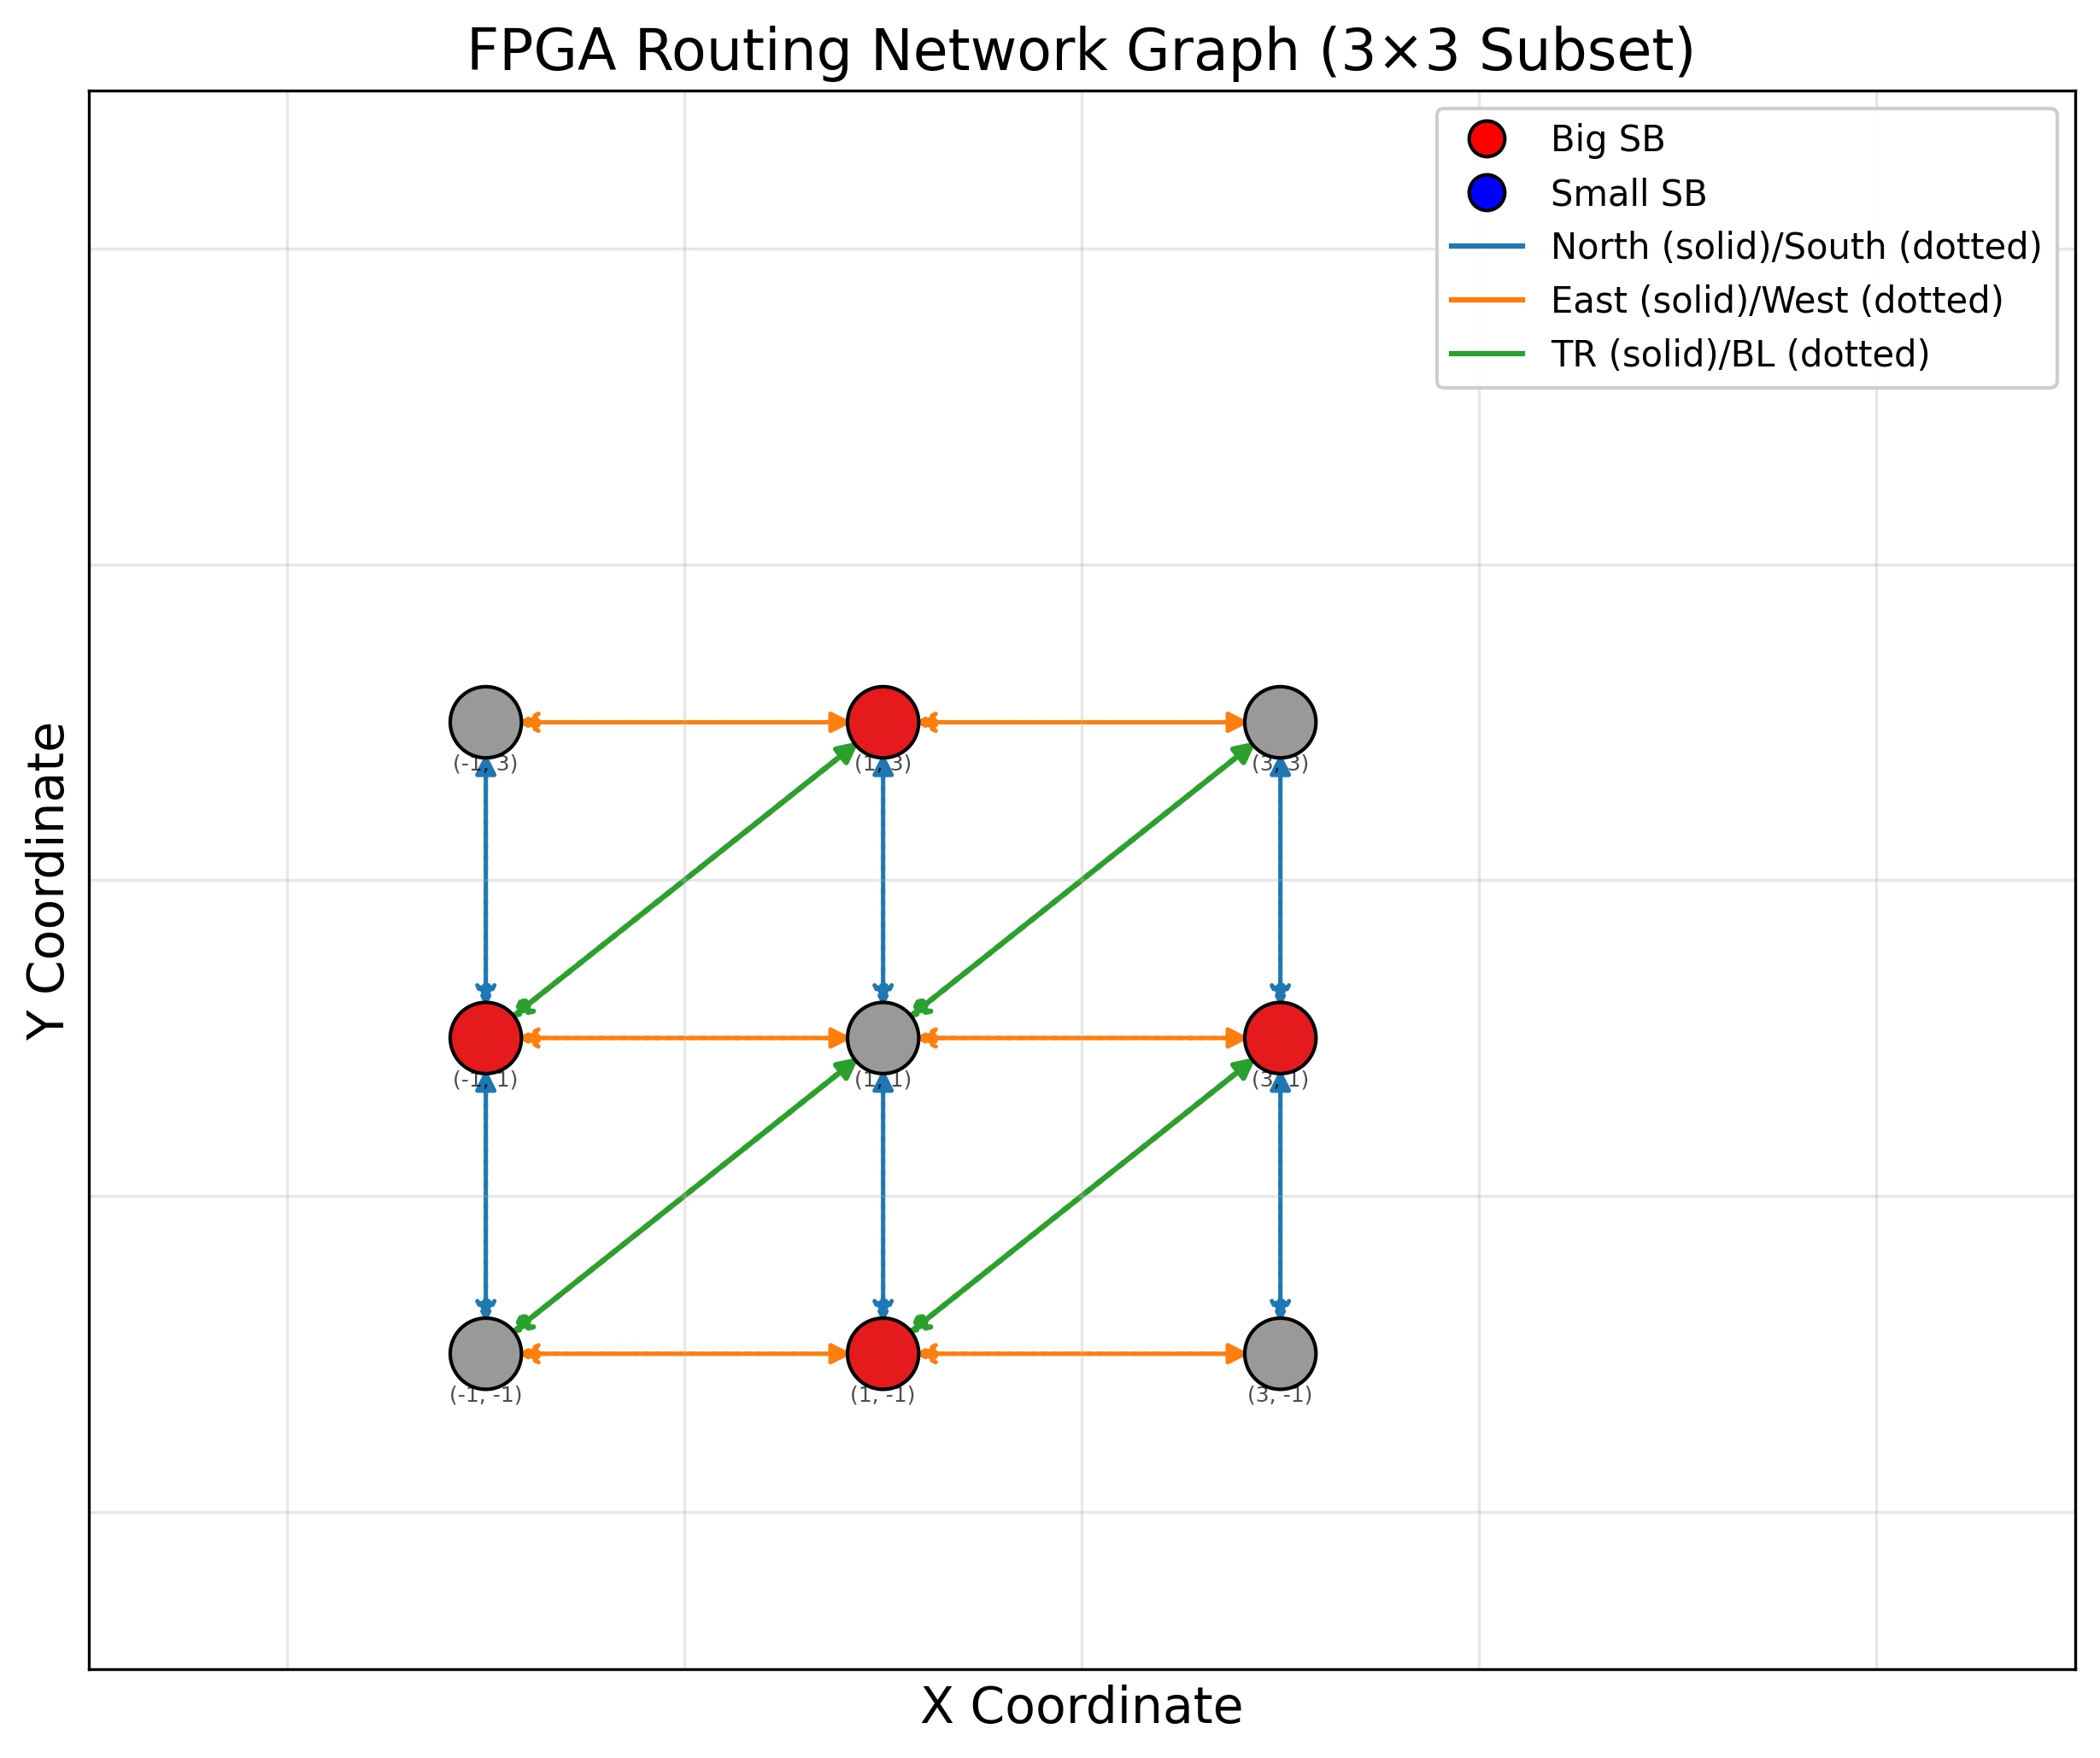

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from matplotlib import rcParams

# === Graph Network Modeling ===
class FPGAGraph:
    def __init__(self, grid):
        self.G = nx.DiGraph()
        self._build_graph(grid)
        
    def _build_graph(self, grid):
        """Convert FPGA grid to directed graph with edge attributes"""
        for coord, sb in grid.items():
            self.G.add_node(coord, type=sb.type)
            
            for direction, target in sb.outputs.items():
                if target and target in grid:
                    self.G.add_edge(coord, target, direction=direction)

    def get_connection_matrix(self):
        """Return DataFrame of directional connections"""
        edges = [(u, v, d['direction']) for u,v,d in self.G.edges(data=True)]
        return pd.DataFrame(edges, columns=['Source', 'Target', 'Direction'])

# === Analysis === 
fpga_graph = FPGAGraph(grid)
connection_df = fpga_graph.get_connection_matrix()

# Connection statistics
direction_counts = connection_df['Direction'].value_counts()
sb_degrees = pd.DataFrame({
    'OutDegree': dict(fpga_graph.G.out_degree()),
    'InDegree': dict(fpga_graph.G.in_degree())
})

print("Directional Connection Counts:")
print(direction_counts)
print("\nSwitch Box Degree Statistics:")
print(sb_degrees.describe())

# === Enhanced Visualization ===
def plot_graph_subset():
    rcParams.update({'font.size': 9, 'font.family': 'DejaVu Sans'})
    
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    pos = {node: (node[0], node[1]) for node in fpga_graph.G.nodes()}
    
    # Plot parameters
    node_size = 400  # Reduced from original 800
    arrow_size = 12
    edge_styles = {
        'N': {'color': '#1f77b4', 'style': 'solid', 'width': 1.2},
        'S': {'color': '#1f77b4', 'style': 'dotted', 'width': 1.2},
        'E': {'color': '#ff7f0e', 'style': 'solid', 'width': 1.2},
        'W': {'color': '#ff7f0e', 'style': 'dotted', 'width': 1.2},
        'TR': {'color': '#2ca02c', 'style': 'solid', 'width': 1.5},
        'BL': {'color': '#2ca02c', 'style': 'dotted', 'width': 1.5}
    }

    # Plot nodes
    nx.draw_networkx_nodes(
        fpga_graph.G, pos, node_size=node_size,
        node_color=[sb['type'] == 'big' for _, sb in fpga_graph.G.nodes(data=True)],
        cmap=plt.cm.Set1, edgecolors='k', ax=ax
    )

    # Plot edges with direction styling
    for direction, style in edge_styles.items():
        edges = [(u, v) for u, v, d in fpga_graph.G.edges(data=True) 
                if d['direction'] == direction]
        nx.draw_networkx_edges(
            fpga_graph.G, pos, edgelist=edges,
            edge_color=style['color'], 
            style=style['style'],
            width=style['width'],
            arrowsize=arrow_size,
            arrowstyle='-|>',
            ax=ax
        )

    # Annotate coordinates
    for coord in pos:
        ax.text(coord[0], coord[1]-0.3, f"{coord}", 
                ha='center', fontsize=6, alpha=0.7)

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Big SB',
                  markerfacecolor='red', markersize=10, markeredgecolor='k'),
        plt.Line2D([0], [0], marker='o', color='w', label='Small SB',
                  markerfacecolor='blue', markersize=10, markeredgecolor='k'),
        plt.Line2D([0], [0], color='#1f77b4', linestyle='solid', 
                  label='North (solid)/South (dotted)'),
        plt.Line2D([0], [0], color='#ff7f0e', linestyle='solid', 
                  label='East (solid)/West (dotted)'),
        plt.Line2D([0], [0], color='#2ca02c', linestyle='solid', 
                  label='TR (solid)/BL (dotted)')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', framealpha=0.95)
    plt.title("FPGA Routing Network Graph (3×3 Subset)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, alpha=0.3)
    plt.xlim(-3, 7)
    plt.ylim(-3, 7)
    plt.savefig('fpga_graph_analysis.pdf', bbox_inches='tight')
    plt.show()

# Plot a manageable subset
subset_nodes = [(-1,-1), (1,-1), (3,-1),
               (-1,1), (1,1), (3,1),
               (-1,3), (1,3), (3,3)]
fpga_graph.G = fpga_graph.G.subgraph(subset_nodes)
plot_graph_subset()


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats
class RobustFPGAGraph:
    def __init__(self, grid):
        self.G = nx.DiGraph()
        self._build_realistic_connections(grid)
        
    def _build_realistic_connections(self, grid):
        """Model actual FPGA routing patterns"""
        for coord, sb in grid.items():
            # Cardinal connections (span multiple tiles)
            for dx, dy, dir in [(0, 2, 'N'), (2, 0, 'E'), 
                              (0, -2, 'S'), (-2, 0, 'W')]:
                target = (coord[0]+dx, coord[1]+dy)
                if target in grid:
                    self.G.add_edge(coord, target, direction=dir)
            
            # Diagonal connections
            for dx, dy, dir in [(2, 2, 'TR'), (-2, -2, 'BL')]:
                target = (coord[0]+dx, coord[1]+dy)
                if target in grid:
                    self.G.add_edge(coord, target, direction=dir)
class AdvancedFPGAnalytics:
    def __init__(self, grid, graph):
        self.grid = grid
        self.G = graph.G
        self.results = {}
        self._validate_graph()

    def _validate_graph(self):
        """Ensure graph integrity before analysis"""
        assert nx.is_strongly_connected(self.G), "Graph contains disconnected components"
        assert len(self.grid) == len(self.G.nodes()), "Grid-Graph node mismatch"

    def _calculate_structural_properties(self):
        """Compute fundamental network metrics"""
        return {
            'assortativity': nx.degree_assortativity_coefficient(self.G),
            'clustering': nx.average_clustering(self.G),
            'betweenness': pd.Series(nx.betweenness_centrality(self.G)).describe(),
            'efficiency': nx.global_efficiency(self.G)
        }

    def _perform_spatial_analysis(self):
        """Analyze geometric vs network distances"""
        spatial_dist = []
        path_dist = []
        
        nodes = list(self.G.nodes())
        for _ in range(1000):
            u, v = np.random.choice(nodes, 2, False)
            spatial = np.hypot(u[0]-v[0], u[1]-v[1])
            try:
                path = nx.shortest_path_length(self.G, u, v)
                spatial_dist.append(spatial)
                path_dist.append(path)
            except nx.NetworkXNoPath:
                continue

        return {
            'distance_correlation': np.corrcoef(spatial_dist, path_dist)[0,1],
            'hop_ratio': np.mean(np.array(path_dist)/np.array(spatial_dist))
        }

    def _analyze_routing_resources(self):
        """Detailed directional capacity analysis"""
        dir_caps = pd.DataFrame(
            [(k, v.type, d['direction']) 
             for k, v in self.grid.items() 
             for _, d in self.G.out_edges(k, data=True)],
            columns=['Node', 'Type', 'Direction']
        )
        
        return dir_caps.groupby(['Type', 'Direction']).size().unstack()

    def full_analysis(self):
        """Execute complete analysis suite"""
        self.results.update(self._calculate_structural_properties())
        self.results.update(self._perform_spatial_analysis())
        self.results['routing_matrix'] = self._analyze_routing_resources()
        return self

    def generate_report(self):
        """Generate publication-ready outputs"""
        report = {
            "Structural Properties": pd.DataFrame([self.results['assortativity'], 
                                                 self.results['clustering']]),
            "Distance Analysis": pd.DataFrame([self.results['distance_correlation'],
                                             self.results['hop_ratio']]),
            "Routing Capacity": self.results['routing_matrix']
        }
        return report

# Usage
advanced_analytics = AdvancedFPGAnalytics(grid, fpga_graph).full_analysis()
report = advanced_analytics.generate_report()


AssertionError: Grid-Graph node mismatch